<a href="https://colab.research.google.com/github/evinracher/3008410-intelligent-systems/blob/main/week2/exercise2/emotion_analysis_with_tokenizer_and_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Emotion Analysis with Transformers

## Introduction

**Emotion analysis**, also known as *emotion classification*, is a task in **Natural Language Processing (NLP)** that aims to automatically identify emotional states expressed in text, such as joy, sadness, anger, or fear.

This task evolved from **sentiment analysis**, which originally emerged within the field of data mining in the late 1990s and early 2000s. At that time, companies sought to analyze large volumes of customer reviews, online comments, and survey responses to determine whether opinions about a product or service were positive or negative.

Over time, researchers recognized that simple polarity classification (positive/negative) was insufficient to capture the complexity of human language. As a result, the field progressed toward more fine-grained emotional categorization, drawing inspiration from psychological theories of basic universal emotions.

From a technical perspective, early approaches relied on statistical methods such as Naive Bayes and Support Vector Machines (SVM). Later, deep learning models like RNNs and LSTMs improved the ability to capture sequential dependencies in text. However, a major breakthrough occurred in 2018 with the introduction of Transformer-based models (such as BERT and its variants), which significantly improved performance by leveraging bidirectional contextual representations and attention mechanisms.

In this notebook, we will explore how to apply Transformer-based models for emotion classification in text.

| Feature                           | `bert-base-uncased`                         | `roberta-base`                            | `dccuchile/bert-base-spanish-wwm-cased`         |
|-----------------------------------|---------------------------------------------|--------------------------------------------|--------------------------------------------------|
| **Architecture**                  | BERT                                        | RoBERTa (improved BERT)                    | BERT                                             |
| **Casing**                        | Uncased (lowercase only)                    | Cased (case-sensitive)                     | Cased                                            |
| **Language**                      | English                                     | English                                    | Spanish                                          |
| **Model Size**                    | 110 million parameters                      | 125 million parameters                     | 110 million parameters                           |
| **Pretraining Data**              | English Wikipedia + BooksCorpus             | CC-News, OpenWebText, Books, Stories       | Spanish Wikipedia + OPUS + Tatoeba               |
| **Pretraining Data Size (Words)** | ~3.3 billion words                          | ~32 billion words                          | ~2 billion words                                 |
| **Pretraining Data Size (Tokens)**| ~3.3 billion tokens                         | ~300 billion tokens                        | ~2.6 billion tokens                              |
| **Pretraining Data Size (GB)**    | ~16 GB                                      | ~160 GB                                    | ~3 GB                                            |
| **Tokenizer**                     | WordPiece                                   | Byte-Pair Encoding (BPE)                   | WordPiece with Whole Word Masking (WWM)          |
| **Embedding Dimension**           | 768                                         | 768                                        | 768                                              |
| **Number of Layers (Transformers)**| 12                                          | 12                                         | 12                                               |
| **Attention Heads**              | 12                                          | 12                                         | 12                                               |
| **Performance on English**        | Good                                        | Very good                                  | Poor                                             |
| **Performance on Spanish**        | Poor                                        | Medium                                     | Very good                                        |
| **Recommended Use Cases**         | English NLP tasks                           | English NLP tasks (higher performance)     | Spanish NLP tasks (sentiment, classification)    |
| **Hugging Face Model ID**         | `bert-base-uncased`                         | `roberta-base`                             | `dccuchile/bert-base-spanish-wwm-cased`          |

## Import libraries

In [ ]:
# ===== LIBRERÍAS PRINCIPALES =====
import pandas as pd  # Manipulación de datos en formato tabular
from transformers import AutoTokenizer, AutoModel  # Carga automática de tokenizadores y modelos BERT
from torch.utils.data import DataLoader  # Carga de datos en lotes (batches) para entrenamiento
from datasets import Dataset  # Creación de datasets optimizados para transformers
import torch  # Framework principal de deep learning
import torch.nn as nn  # Módulos de redes neuronales

# ===== MÉTRICAS Y EVALUACIÓN =====
from sklearn.metrics import f1_score, accuracy_score  # Cálculo de métricas de desempeño
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Matriz de confusión
import numpy as np  # Operaciones numéricas
from tqdm import tqdm  # Barra de progreso para loops

# ===== VISUALIZACIÓN =====
import matplotlib.pyplot as plt  # Gráficos
import seaborn as sns  # Visualizaciones estadísticas mejoradas

# ===== PROCESAMIENTO DE DATOS =====
from sklearn.model_selection import train_test_split  # División de datos en train/val

## Load Data

https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [ ]:
# ===== CARGA DE DATOS =====
# Cargar conjunto de entrenamiento: contiene textos y sus etiquetas de emoción
train_df = pd.read_csv("/kaggle/input/datasets/praveengovi/emotions-dataset-for-nlp/train.txt", sep=";", header=None, names=['text','label'])
# Cargar conjunto de validación: usado para ajustar hiperparámetros durante entrenamiento
val_df = pd.read_csv("/kaggle/input/datasets/praveengovi/emotions-dataset-for-nlp/val.txt", sep=";", header=None, names=['text', 'label'])
# Cargar conjunto de prueba: usado para evaluación final del modelo
test_df = pd.read_csv("/kaggle/input/datasets/praveengovi/emotions-dataset-for-nlp/test.txt", sep=";", header=None, names=['text', 'label'])

## Unique tags

In [ ]:
# ===== PROCESAMIENTO DE ETIQUETAS DE EMOCIONES =====
# Extraer todas las etiquetas únicas de emociones del conjunto de entrenamiento
emotion_labels = train_df['label'].unique().tolist()

# Crear mapeo bidireccional: texto -> número para codificar las emociones
label2id = {label: idx for idx, label in enumerate(emotion_labels)}  # Ej: {'joy': 0, 'sadness': 1, ...}
id2label = {v: k for k, v in label2id.items()}  # Inverso: {0: 'joy', 1: 'sadness', ...}

print("Number of emotions:", len(emotion_labels))
print("Labels:", emotion_labels)

# ===== CODIFICACIÓN NUMÉRICA DE ETIQUETAS =====
# Convertir etiquetas de texto a números para que el modelo pueda procesarlas
train_df['label_id'] = train_df['label'].map(label2id)
val_df['label_id'] = val_df['label'].map(label2id)
test_df['label_id'] = test_df['label'].map(label2id)

Number of emotions: 6
Labels: ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']


/tmp/ipykernel_55/3769127976.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')  # Gráfico de barras


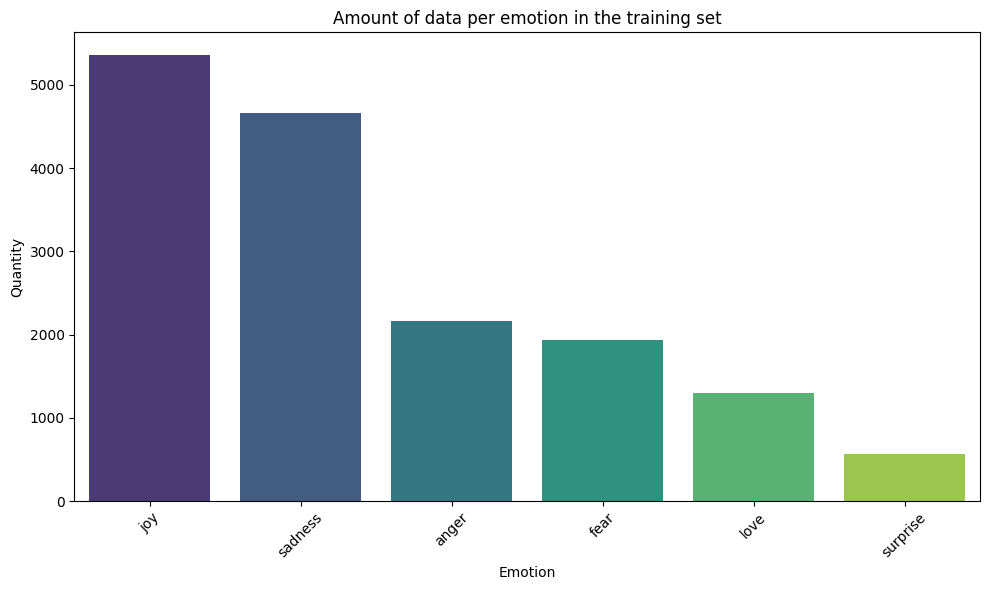

Total rows in the training set: 16000
Total rows in the validation set: 2000
Total rows in the test set: 2000
Total rows in the entire dataset: 20000


In [ ]:
# ===== ANÁLISIS DE DISTRIBUCIÓN DE DATOS =====
# Contar cuántos ejemplos hay para cada emoción en el conjunto de entrenamiento
emotion_counts = train_df['label'].value_counts().sort_values(ascending=False)

# ===== VISUALIZACIÓN DE FRECUENCIA DE EMOCIONES =====
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')  # Gráfico de barras
plt.title("Amount of data per emotion in the training set")
plt.xlabel("Emotion")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===== ESTADÍSTICAS DEL DATASET =====
print("Total rows in the training set:", len(train_df))
print("Total rows in the validation set:", len(val_df))
print("Total rows in the test set:", len(test_df))
print("Total rows in the entire dataset:", len(train_df) + len(val_df) + len(test_df))

## Tokenization

In [ ]:
# ===== CARGA DEL TOKENIZADOR =====
# Cargar el tokenizador BERT preentrenado (convierte texto en tokens)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# ===== FUNCIÓN DE TOKENIZACIÓN =====
def tokenize(batch):
    """Convierte textos en tokens y genera máscaras de atención. Padding hasta 128 tokens."""
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

# ===== PREPARACIÓN DE DATASETS =====
# Convertir DataFrames de pandas a Datasets optimizados y aplicar tokenización
train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# Renombrar columna de etiquetas para que sea compatible con los modelos de transformers
train_ds = train_ds.rename_column("label_id", "labels")
val_ds = val_ds.rename_column("label_id", "labels")

# Convertir a formato PyTorch y seleccionar solo las columnas necesarias
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# ===== CREACIÓN DE DATA LOADERS =====
# DataLoader carga datos en lotes (batches) para eficiencia computacional
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)  # Mezcla datos en entrenamiento
val_loader = DataLoader(val_ds, batch_size=128)  # Sin mezcla en validación

# ===== DEFINICIÓN DEL MODELO =====
class BertForSimpleClassification(nn.Module):
    """Modelo personalizado que añade una capa clasificadora sobre BERT."""
    def __init__(self, num_labels):
        super().__init__()
        # Cargar modelo BERT preentrenado
        self.bert = AutoModel.from_pretrained("bert-base-uncased")
        # Capa dropout para regularización (reduce sobreajuste)
        self.dropout = nn.Dropout(0.3)
        # Capa lineal de clasificación: convierte embeddings BERT a probabilidades de emociones
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        """Paso forward: BERT -> Dropout -> Clasificador."""
        # Obtener embeddings y outputs de BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Usar el embedding [CLS] de BERT (resumen del texto) como entrada al clasificador
        pooled_output = outputs.pooler_output
        # Aplicar dropout para regularización
        pooled_output = self.dropout(pooled_output)
        # Obtener logits (scores sin normalizar) para cada emoción
        logits = self.classifier(pooled_output)
        return logits

# ===== CONFIGURACIÓN DEL ENTRENAMIENTO =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSimpleClassification(num_labels=len(emotion_labels)).to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print("Train")
losses = []
val_losses = []

# ===== BUCLE DE ENTRENAMIENTO =====
for epoch in range(3):  # 3 épocas
    print("Starting Epoch", epoch)
    model.train()  # Modo entrenamiento (habilita dropout y batch norm)
    total_loss = 0

    # Iterar sobre batches del conjunto de entrenamiento
    for i, batch in enumerate(tqdm(train_loader, desc="Training")):
        # Limpiar gradientes acumulados del batch anterior
        optimizer.zero_grad()

        # Mover datos al dispositivo (GPU/CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass: obtener predicciones
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

        # Calcular pérdida comparando predicciones con etiquetas reales
        loss = loss_fn(logits, labels)

        # Backward pass: calcular gradientes
        loss.backward()

        # Actualizar pesos del modelo
        optimizer.step()

        # Acumular pérdida para estadísticas
        total_loss += loss.item()

    # Imprimir pérdida promedio del epoch
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")
    losses.append(total_loss / len(train_loader))

    # ===== EVALUACIÓN EN VALIDACIÓN =====
    model.eval()  # Modo evaluación (desactiva dropout)
    val_loss = 0
    preds, true_labels = [], []

    # No calcular gradientes durante validación (ahorra memoria)
    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_loader, desc="Validating")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Predicción en validación
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            # Convertir logits a predicciones (índice con valor máximo)
            pred_labels = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(pred_labels)
            true_labels.extend(labels.cpu().numpy())

    # Almacenar pérdida de validación
    val_losses.append(val_loss / len(val_loader))

    # Calcular métricas de desempeño
    f1 = f1_score(true_labels, preds, average='macro')  # F1-score promedio entre emociones
    acc = accuracy_score(true_labels, preds)  # Exactitud general
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
    print(f"Validation F1-score: {f1:.4f}, Accuracy: {acc:.4f}")

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train
Starting Epoch 0


Training: 100%|██████████| 250/250 [04:56<00:00,  1.18s/it]


Epoch 1: Loss = 0.7772


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Validation Loss: 0.2304
Validation F1-score: 0.8976, Accuracy: 0.9220
Starting Epoch 1


Training: 100%|██████████| 250/250 [04:56<00:00,  1.19s/it]


Epoch 2: Loss = 0.1731


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]


Validation Loss: 0.1694
Validation F1-score: 0.9085, Accuracy: 0.9335
Starting Epoch 2


Training: 100%|██████████| 250/250 [04:56<00:00,  1.19s/it]


Epoch 3: Loss = 0.1187


Validating: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]

Validation Loss: 0.1664
Validation F1-score: 0.9095, Accuracy: 0.9320


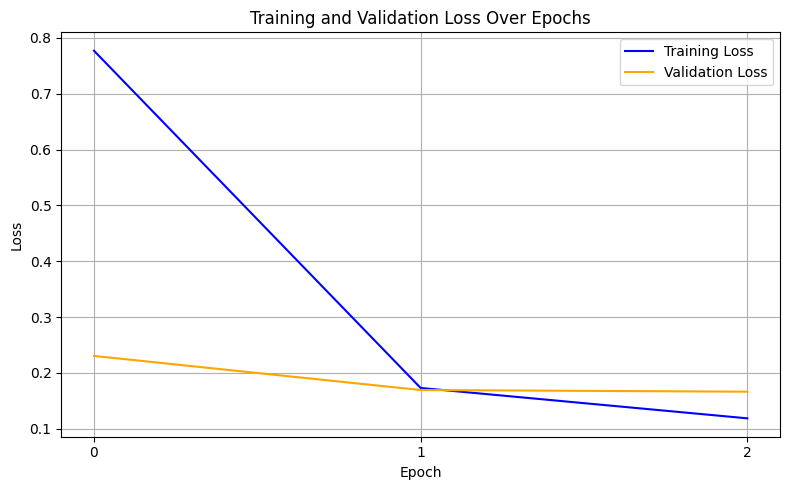

In [ ]:
# ===== VISUALIZACIÓN DE PÉRDIDAS =====
plt.figure(figsize=(8, 5))

# Graficar pérdida de entrenamiento (línea azul)
plt.plot(losses, label='Training Loss', color='blue')

# Graficar pérdida de validación (línea naranja)
plt.plot(val_losses, label='Validation Loss', color='orange')

# Configuración del gráfico
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(losses)))  # Etiquetas en eje X para cada época
plt.legend()  # Mostrar leyenda
plt.grid(True)  # Grilla para mejor lectura
plt.tight_layout()
plt.show()

Evaluating: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]

Final Validation F1-score: 0.9095, Accuracy: 0.9320


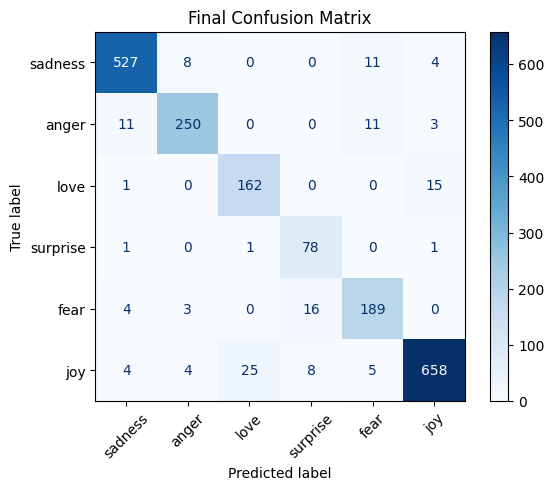

In [ ]:
# ===== EVALUACIÓN FINAL DEL MODELO =====
model.eval()  # Modo evaluación
preds, true_labels = [], []

# Sin gradientes para evaluación
with torch.no_grad():
    # Iterar sobre batches de validación
    for i, batch in enumerate(tqdm(val_loader, desc="Evaluating")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Obtener predicciones
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        # Convertir logits a indices de clase (emoción predicha)
        pred_labels = torch.argmax(logits, dim=1).cpu().numpy()

        # Almacenar predicciones y etiquetas verdaderas
        preds.extend(pred_labels)
        true_labels.extend(labels.cpu().numpy())

# ===== MÉTRICAS FINALES =====
f1 = f1_score(true_labels, preds, average='macro')  # F1-score: balance entre precisión y recall
acc = accuracy_score(true_labels, preds)  # Exactitud: % de predicciones correctas
print(f"Final Validation F1-score: {f1:.4f}, Accuracy: {acc:.4f}")

# ===== MATRIZ DE CONFUSIÓN =====
# Muestra cuáles emociones se confunden entre sí
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Final Confusion Matrix")
plt.show()

## Test the model

In [ ]:
# ===== FUNCIÓN DE PREDICCIÓN =====
def predict_text(text, model, tokenizer, device, id2label):
    """Predice la emoción de un texto dado."""
    model.eval()  # Modo evaluación

    # Tokenizar el texto de entrada
    inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=128)

    # Mover tokens a dispositivo
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Predicción
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        # Obtener índice de la emoción con mayor probabilidad
        pred_label_id = torch.argmax(logits, dim=1).item()
        # Convertir índice a nombre de emoción
        pred_label = id2label[pred_label_id]

    return pred_label

# ===== PRUEBA CON EJEMPLO =====
example_text = "No matter how stressful my day is, hearing your voice instantly makes me feel at peace."
predicted_emotion = predict_text(example_text, model, tokenizer, device, id2label)
print(f"Text: {example_text}")
print(f"Predicted Emotion: {predicted_emotion}")

Text: No matter how stressful my day is, hearing your voice instantly makes me feel at peace.
Predicted Emotion: joy


## #1 Activity - It's your turn

1. **Test the model with 5 original phrases in English. What are your conclusions?**

2. **What happens if you increase the number of epochs during training?**

3. **Test the tokenizer `"roberta-base"`. Are there any differences compared to BERT's tokenizer?**

4. **What effect does changing the dropout probability have on the model's performance?**

5. **What happens if you increase or decrease the learning rate?**

6. **Test the following phrases. What were the results? What conclusions can you draw?**

   - I smiled, but inside, everything was unraveling.  
   - It’s funny how silence can be louder than screams.  
   - He said he was proud, but I saw the disappointment in his eyes.  
   - I don’t miss them, I miss who I thought they were.  
   - She laughed like nothing mattered, though everything did.  
   - I’m not angry, just tired of always pretending I’m okay.  
   - Hope is the cruelest of all lies.  
   - Every time I get close to happiness, I sabotage it myself.  
   - They say time heals, but I think it just teaches you how to hide the pain better.  
   - He was the calm before every storm I never saw coming.

7. **Try the following sentences. Is Bert able to understand sarcasm? What are your conclusions?**

    - Life’s good, you should get one.
    - No, you don’t have to repeat yourself. I was ignoring you the first time.
    - Unless your name is Google, stop acting like you know everything.
    - Just because I don’t care doesn’t mean I don’t understand.

## BERT, Are you ready to analysis data in another language? BETO VS BERT - The great fight


In the realm of natural language processing, BETO and BERT clashed in an epic battle. BERT, the master of English, unleashed its power to understand complex contexts, while BETO, the champion of Spanish, showcased its skill in capturing the subtle nuances and emotions of its language. Though rivals, they soon realized that their true strength lay in complementing each other, joining forces to advance toward a future where all languages are understood with precision.

## Load Data
https://www.kaggle.com/datasets/philipsanm/sentiment-analysis-in-spanish-tweets

In [ ]:
# ===== CARGA DE DATASET EN ESPAÑOL =====
# Cargar dataset de análisis de sentimiento en tweets en español
df = pd.read_csv("/kaggle/input/datasets/philipsanm/sentiment-analysis-in-spanish-tweets/sentiment_analysis_dataset.csv")

# Ver los sentimientos únicos disponibles en el dataset
print(set(df['sentiment']))

# ===== MAPEO DE ETIQUETAS DE SENTIMIENTO =====
# Crear mapeo bidireccional: sentimiento (texto) -> número
label2id = {label: idx for idx, label in enumerate(df['sentiment'].unique())}
id2label = {v: k for k, v in label2id.items()}
# Añadir columna con IDs numéricos
df['label_id'] = df['sentiment'].map(label2id)

# ===== DIVISIÓN TRAIN/VALIDACIÓN =====
# Dividir datos: 80% entrenamiento, 20% validación
# stratify asegura que la proporción de clases sea similar en ambos conjuntos
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_id'], random_state=42)

{'powerful', 'joyful', 'scared', 'mad', 'peaceful', 'sad'}


## Emotions Distribution

/tmp/ipykernel_55/1185867026.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')


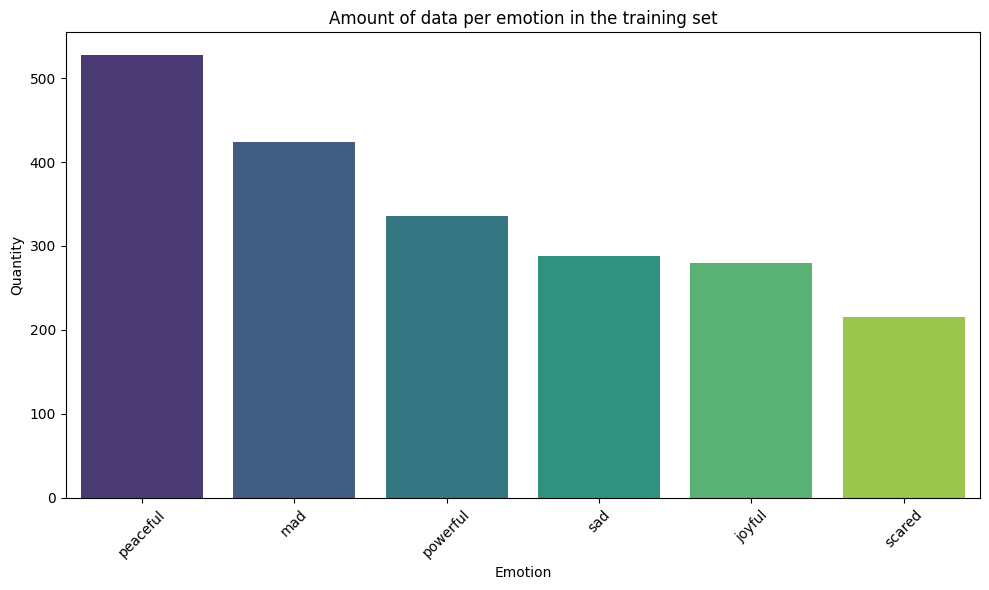

Total rows in the training set: 2072
Total rows in the validation set: 518
Total rows in the entire dataset: 2590


In [ ]:
# ===== ANÁLISIS DE DISTRIBUCIÓN DE SENTIMIENTOS =====
# Contar frecuencia de cada sentimiento en datos de entrenamiento
emotion_counts = train_df['sentiment'].value_counts().sort_values(ascending=False)

# ===== VISUALIZACIÓN DE DISTRIBUCIÓN =====
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_counts.index, y=emotion_counts.values, palette='viridis')
plt.title("Amount of data per emotion in the training set")
plt.xlabel("Emotion")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===== ESTADÍSTICAS GENERALES =====
print("Total rows in the training set:", len(train_df))
print("Total rows in the validation set:", len(val_df))
print("Total rows in the entire dataset:", len(train_df) + len(val_df))

## Model Implementation

In [ ]:
# ===== CARGA DEL TOKENIZADOR BETO =====
# BETO es la versión en español de BERT, entrenada con datos en español
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

# ===== FUNCIÓN DE TOKENIZACIÓN PARA BETO =====
def tokenize(batch):
    """Tokeniza textos en español manteniendo mayúsculas/minúsculas (cased)."""
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

# ===== PREPARACIÓN DE DATASETS PARA BETO =====
train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True)
val_ds = Dataset.from_pandas(val_df).map(tokenize, batched=True)

# Renombrar columnas para compatibilidad
train_ds = train_ds.rename_column("label_id", "labels")
val_ds = val_ds.rename_column("label_id", "labels")

# Convertir a formato PyTorch
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# ===== DATA LOADERS PARA BETO =====
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)

# ===== DEFINICIÓN DEL MODELO BETO =====
class BertForSimpleClassification(nn.Module):
    """Arquitectura igual a BERT pero optimizada para español."""
    def __init__(self, num_labels):
        super().__init__()
        # Cargar BETO preentrenado en datos españoles
        self.bert = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
        # Dropout para regularización
        self.dropout = nn.Dropout(0.3)
        # Clasificador final
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        """Forward pass del modelo."""
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# ===== CONFIGURACIÓN Y SETUP DEL MODELO =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSimpleClassification(num_labels=len(label2id)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print("Train")
losses = []
val_losses = []

# ===== BUCLE DE ENTRENAMIENTO PARA BETO =====
for epoch in range(3):  # 3 épocas
    print("Starting Epoch", epoch)
    model.train()  # Modo entrenamiento
    total_loss = 0

    # Entrenamiento
    for i, batch in enumerate(tqdm(train_loader, desc="Training")):
        optimizer.zero_grad()  # Limpiar gradientes previos
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)

        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")
    losses.append(total_loss / len(train_loader))

    # ===== VALIDACIÓN =====
    model.eval()  # Modo evaluación
    val_loss = 0
    preds, true_labels = [], []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_loader, desc="Validating")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            pred_labels = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(pred_labels)
            true_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    f1 = f1_score(true_labels, preds, average='macro')
    acc = accuracy_score(true_labels, preds)
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")
    print(f"Validation F1-score: {f1:.4f}, Accuracy: {acc:.4f}")

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/2072 [00:00<?, ? examples/s]

Map:   0%|          | 0/518 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train
Starting Epoch 0


Training:   0%|          | 0/33 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Training: 100%|██████████| 33/33 [00:38<00:00,  1.17s/it]


Epoch 1: Loss = 1.7342


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Validation Loss: 1.6613
Validation F1-score: 0.1505, Accuracy: 0.3089
Starting Epoch 1


Training: 100%|██████████| 33/33 [00:38<00:00,  1.17s/it]


Epoch 2: Loss = 1.5107


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Validation Loss: 1.3502
Validation F1-score: 0.4447, Accuracy: 0.5019
Starting Epoch 2


Training: 100%|██████████| 33/33 [00:38<00:00,  1.17s/it]


Epoch 3: Loss = 1.0677


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

Validation Loss: 0.9835
Validation F1-score: 0.6121, Accuracy: 0.6332


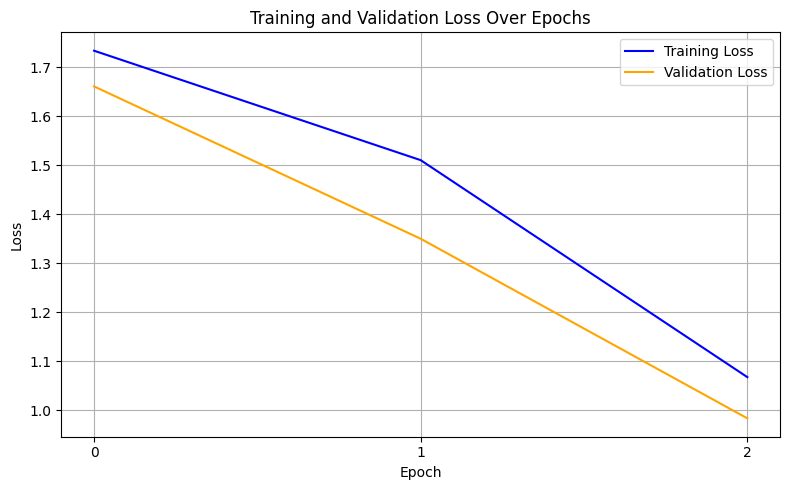

In [ ]:
# ===== VISUALIZACIÓN DE PÉRDIDAS DE BETO =====
plt.figure(figsize=(8, 5))

# Graficar pérdida de entrenamiento
plt.plot(losses, label='Training Loss', color='blue')

# Graficar pérdida de validación
plt.plot(val_losses, label='Validation Loss', color='orange')

# Configuración del gráfico
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(losses)))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Final F1-score: 0.6121, Accuracy: 0.6332


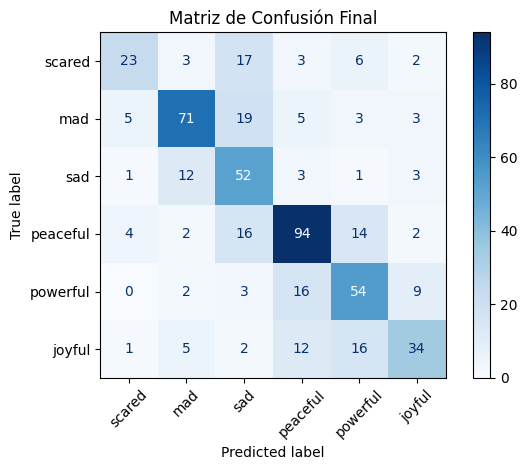

In [ ]:
# ===== EVALUACIÓN FINAL DE BETO =====
model.eval()  # Modo evaluación
preds, true_labels = [], []

# Evaluación sin cálculo de gradientes
with torch.no_grad():
    for i, batch in enumerate(tqdm(val_loader, desc="Evaluating")):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Predicción
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_labels = torch.argmax(logits, dim=1).cpu().numpy()

        # Almacenar resultados
        preds.extend(pred_labels)
        true_labels.extend(labels.cpu().numpy())

# ===== MÉTRICAS FINALES DE BETO =====
f1 = f1_score(true_labels, preds, average='macro')  # F1 promedio
acc = accuracy_score(true_labels, preds)  # Exactitud
print(f"Final F1-score: {f1:.4f}, Accuracy: {acc:.4f}")

# ===== MATRIZ DE CONFUSIÓN FINAL =====
# Visualiza qué sentimientos se confunden entre sí
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión Final")
plt.tight_layout()
plt.show()

## Test the model

In [ ]:
# ===== TEXTOS DE PRUEBA EN ESPAÑOL =====
# Lista de frases en español para probar el modelo BETO
test_texts = [
    "Estoy muy feliz con los resultados.",
    "No puedo creer lo triste que me siento hoy.",
    "Me siento frustrado y enojado por lo que pasó.",
    "Qué sorpresa tan agradable recibir esa noticia.",
    "Tengo miedo de lo que pueda pasar mañana.",
    "Me siento íncreible, perdí todos los parciales"
]

# ===== TOKENIZACIÓN DE TEXTOS DE PRUEBA =====
# Tokenizar todos los textos a la vez
inputs = tokenizer(test_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

# Eliminar token_type_ids si está presente (no es necesario para BETO)
inputs.pop("token_type_ids", None)

# Mover tokens a dispositivo
inputs = {k: v.to(device) for k, v in inputs.items()}

# ===== PREDICCIÓN EN LOTE =====
model.eval()  # Modo evaluación
with torch.no_grad():
    # Obtener logits para todos los textos
    logits = model(**inputs)
    # Convertir logits a probabilidades
    probs = torch.softmax(logits, dim=1)
    # Obtener índice de sentimiento predicho
    preds = torch.argmax(probs, dim=1)

# ===== CONVERTIR ÍNDICES A NOMBRES DE SENTIMIENTOS =====
pred_labels = [id2label[i.item()] for i in preds]

# ===== MOSTRAR RESULTADOS =====
for text, label in zip(test_texts, pred_labels):
    print(f"Text: {text}\nPredicted Sentiment: {label}\n")

Text: Estoy muy feliz con los resultados.
Predicted Sentiment: powerful

Text: No puedo creer lo triste que me siento hoy.
Predicted Sentiment: scared

Text: Me siento frustrado y enojado por lo que pasó.
Predicted Sentiment: mad

Text: Qué sorpresa tan agradable recibir esa noticia.
Predicted Sentiment: powerful

Text: Tengo miedo de lo que pueda pasar mañana.
Predicted Sentiment: scared

Text: Me siento íncreible, perdí todos los parciales
Predicted Sentiment: peaceful



## #2 Activity - It's your turn

1. **Test the model BETO and BERT with 5 original phrases in Spanish. What are your conclusions? What are the differences between these models**

2. **What happens if you increase the number of epochs during training?**

3. **The robustness of datasets (English/Spanish) could it affect the performance of the model? Argument in this specific case emotion-dataset-for-nlp vs sentiment-analysis-in-spanish-tweets (and BETO vs BERT)**

4. **Test the following phrases in Spanish using BETO and BERT. What were the results? What conclusions can you draw?**

   - ¡Qué buena idea, seguro que eso funcionará... no!  
    - Claro, porque todo en la vida es tan fácil como tú lo dices.  
    - Me encanta cuando me ignoras, es como hablar con la pared.  
    - No te preocupes, tus consejos siempre son súper útiles.  
    - ¡Genial! Otra reunión que podría haber sido un email.  
    - Gracias por aclararlo, porque estaba completamente perdido (modo sarcasmo ON).  
    - Seguro que a todos les importa tu opinión, sí, claro.  
    - ¡Qué sorpresa verte llegar tarde, nunca lo haces!  
    - Me alegra que tus problemas sean más importantes que los míos.  
    - No hay nada mejor que trabajar un domingo, dijo nadie jamás.  
